# Infos about the simulation class

- we generate the kagome lattice site coordinate from a lieb lattice that we sheared  with an angle of 2*pi/3 see
https://doi.org/10.48550/arXiv.2506.15023

- for spin rotations we need to pick a random 3d rotations we thus use a normal distribution of quaternions see method
https://imois.in/posts/random-vectors-and-rotations-in-3d/
https://doi.org/10.1016/B978-0-08-050755-2.50036-1

The 3 first indices of the matrix are for each spins  the first Nx triangles horizontally Ny triangles
vertically and 3 sites in the triangle the left one is 0 the top one is 1 an the left one is 2

- we now have a working simulation we are still tuning the simulations parameters

# Libraries

In [7]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go


In [8]:


class Configuration:
    #"""generate a configuration of spins"""
    
    def __init__(self, a,theta,Nx,Ny, J,seed_control=False,seed=1500):
        #'we create a kagome lattice from parameter a and theta with Nx*Ny*3 spins , '
        self.a,self.theta,self.Nx,self.Ny,self.J=a,theta,Nx,Ny,J,
        self.N=Nx*Ny*3

        # a_1 and a_2 are the lattice translation generating vectors, theta will be 2 pi / 3  
        a_1=a*np.array([1,0])
        a_2=a*np.array([-1*np.cos(theta),np.sin(theta)])
        
        # we construct the triangle unit cell 
        unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
        
        # we construct the grid points from the translations of the lattice
        self.x_l,self.y_l=np.meshgrid(range(Nx),range(Ny))
        A_1=np.tensordot(self.y_l,[a_1,a_1,a_1],axes=0)
        A_2=np.tensordot(self.x_l,[a_2,a_2,a_2],axes=0)

        # the lattice points coordinates are created from adding a unit cell at each grid point
        self.lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+A_1+A_2

        # we create a dim object containing the dimensions of the lattice 
        dim=self.lattice.shape

        #seed control for when we want to test with the same configuration
        if seed_control==True:
            np.random.seed(seed) 

            # Random 3D unit vectors for each spin
        config = 2*np.random.rand(dim[0], dim[1], dim[2], 3) - 1
        Norm = 1 / LA.norm(config, axis=3, keepdims=True)
        self.config = config * Norm
        
        # we want to save some value while the simulation runs for post processing
        self.Energy=[self.total_energy()]
        self.acceptation_rates=[]
        self.angles=[]
        self.overrelaxation_dose=[]


    def get_energy(self,i,j,s):
        """this part implements the sommation over spins nearest spins"""
        
        # A spin that we want to calculate the contribution to the energy
        S=np.array(self.config[i,j,s,:])

        # from the kernel lookup list we see the nearest coordinates
        kernel=np.mod([[[i,j-1,1],[i-1,j,2]],[[i-1,j+1,2],[i,j+1,0]],[[i+1,j-1,1],[i+1,j,0]]],[self.Nx,self.Ny,3])
        # we add the nearest spins
        S_nearest=np.array(self.config[i,j,(s+1)%3,:]+self.config[i,j,(s+2)%3,:])
        S_nearest+=np.array(self.config[kernel[s,0,0],kernel[s,0,1],kernel[s,0,2],:]+self.config[kernel[s,1,0],kernel[s,1,1],kernel[s,1,2],:])
        # we compute the dot product with nearest spins and thus this spin's contribution to the energy 
        E=(self.J)*np.dot(S,S_nearest)
        return E



    def total_energy(self):
        """ this part implements the summation of energy over the whole lattice"""

        E=0
        # we sum over each grid point 
        for i in range(self.Nx):
            for j in range(self.Ny):
                for s in range(3):
                    #we compute each spin contribution
                    E=E+self.get_energy(i,j,s)
        
        return E/2 # we divide by 2 because each spin pair is summed twice


    def delta_energy(self,i,j,s):
        ''' this function is used to compute the energy difference for a flip '''
 
        # we compute the sum of the nearest neighbors of the spin that could be flipped
        kernel=np.mod([[[i,j-1,1],[i-1,j,2]],[[i-1,j+1,2],[i,j+1,0]],[[i+1,j-1,1],[i+1,j,0]]],[self.Nx,self.Ny,3])
        S_nearest=np.array(self.config[i,j,(s+1)%3,:]+self.config[i,j,(s+2)%3,:])
        S_nearest+=np.array(self.config[kernel[s,0,0],kernel[s,0,1],kernel[s,0,2],:]+self.config[kernel[s,1,0],kernel[s,1,1],kernel[s,1,2],:])


        #we compute the difference in energy contribution between the flipped and unaltered spin
        Delta_E=(self.J)*np.dot(self.flipped_spin-self.config[i,j,s,:],S_nearest)

        
        return Delta_E

    def mean_field(self,i,j,s):
        ''' This function computes the direction of the mean spin of neighboring lattice 
        points for the overrelaxation implementation'''

        # from the kernel lookup list we see the nearest coordinates
        kernel=np.mod([[[i,j-1,1],[i-1,j,2]],[[i-1,j+1,2],[i,j+1,0]],[[i+1,j-1,1],[i+1,j,0]]],[self.Nx,self.Ny,3])
        # we add the nearest spins
        S_nearest=np.array(self.config[i,j,(s+1)%3,:]+self.config[i,j,(s+2)%3,:])
        S_nearest+=np.array(self.config[kernel[s,0,0],kernel[s,0,1],kernel[s,0,2],:]+self.config[kernel[s,1,0],kernel[s,1,1],kernel[s,1,2],:])
        
        # we return the normalised nearest spin
        return S_nearest/np.linalg.norm(S_nearest)



    
    def overrelaxation(self, Nf, angles_size=1):
        '''In this part we implement Nf iterations of overrelaxation'''
    
        flips = np.column_stack((
            np.random.randint(0, self.Nx, Nf),
            np.random.randint(0, self.Ny, Nf),
            np.random.randint(0, 3, Nf)
        ))
    
        for pick in flips:
            i, j, s = pick
            S = self.config[i, j, s, :]
            M = self.mean_field(i, j, s)  # normalized sum of neighbors
            # Reflection across mean field direction
            self.config[i, j, s, :] = 2 * np.dot(S, M) * M - S




    def Monte_Carlo(self, Nf, T, small_angles=False, angles_size=0.1):
    
        # tirage des spins à mettre à jour
        flips = np.random.randint([0,0,0], [self.Nx, self.Ny, 3], size=(Nf,3))
        random_uniform_distrib = np.random.uniform(0,1,Nf)
        flag = 0
        beta = 1/T
        deltaE_total = 0
    
        # angles aléatoires pour chaque flip
        if small_angles:
            a = np.pi*(2*np.random.rand(Nf)-1)*angles_size
        else:
            a = np.pi*(2*np.random.rand(Nf)-1)  # grand angle si besoin
    
        for num in range(Nf):
            pick = flips[num]
            spin = self.config[pick[0], pick[1], pick[2], :]
            axis = spin  # rotation autour de son propre axe
    
            # quaternion rotation autour de l'axe
            q = [np.cos(a[num]/2), *(np.sin(a[num]/2) * axis)]
            q /= np.linalg.norm(q)
            r = R.from_quat(q, scalar_first=True)
            self.flipped_spin = r.apply(spin)
    
            # renormalisation pour éviter les erreurs numériques
            self.flipped_spin /= LA.norm(self.flipped_spin)
    
            # delta energy
            deltaE = self.delta_energy(pick[0], pick[1], pick[2])
    
            # Metropolis
            if random_uniform_distrib[num] <= np.exp(-beta*deltaE):
                self.config[pick[0], pick[1], pick[2], :] = self.flipped_spin
                flag += 1
                deltaE_total += deltaE
    
        self.Energy.append(self.Energy[-1] + deltaE_total)
        self.acceptation_rates.append(flag / Nf)
        return flag / Nf, flag

    

    def verify_norm(self):
        """ we have sometimes a problem with the  spin vectors not 
        being normalised after too many rotations due to errors so we normalise them after each 
        flip and we verify their maximum norms"""
        print('norm=',LA.norm(self.config,axis=0).max())


  
    # --- Plot lattice spins (unchanged) ---
    def display_config(self):
        position = np.reshape(self.lattice, (3*self.Nx*self.Ny, 2), order='C')
        arrows   = np.reshape(self.config,  (3*self.Nx*self.Ny, 3), order='C')

        x = position[:, 0]
        y = position[:, 1]
        z = np.zeros_like(x)

        Sx, Sy, Sz = arrows[:, 0], arrows[:, 1], arrows[:, 2]
        X_lines, Y_lines, Z_lines = [], [], []

        for xi, yi, zi, Sxi, Syi, Szi in zip(x, y, z, Sx, Sy, Sz):
            X_lines += [xi, xi + Sxi, None]
            Y_lines += [yi, yi + Syi, None]
            Z_lines += [zi, zi + Szi, None]

        fig = go.Figure()
        fig.add_trace(go.Scatter3d(x=X_lines, y=Y_lines, z=Z_lines, mode="lines"))
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode="markers"))

        fig.update_layout(scene=dict(aspectmode='data'))
        fig.show(renderer="browser")
        



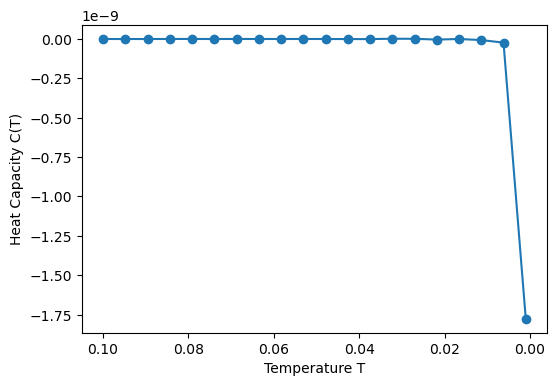

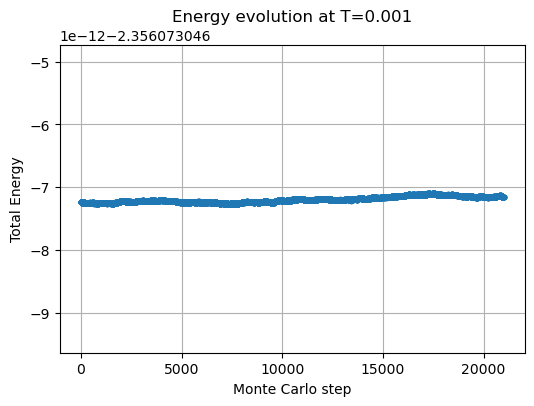

In [9]:
J = 1
Nx = 2
Ny = 2
Nf = 3 * Nx * Ny
theta = 2 * np.pi / 3
a = 1
T = 0.0001

config = Configuration(a, theta, Nx, Ny, J, T)

# Monte Carlo steps for averaging
steps = 2000

Nf_over = Nf  # number of spins for overrelaxation
Nf_SA = Nf    # number of spins for Small Angles

for step in range(steps):
    config.overrelaxation(Nf_over)
    config.Monte_Carlo(Nf_SA, T, small_angles=True, angles_size=0.1)

config.display_config()




T_high = 0.1
T_low = 0.001
n_T = 20
temperatures = np.linspace(T_high, T_low, n_T)




C_list = []
E_avg_list = []

N_mc = 1000  # MC steps per temperature
Nf_over = Nf
Nf_MC = Nf

for T in temperatures:
    E_temp = []
    
    # Thermalization + measurement
    for step in range(N_mc):
        config.overrelaxation(Nf_over)
        config.Monte_Carlo(Nf_MC, T, small_angles=True, angles_size=0.1)
        E_temp.append(config.Energy[-1])
    
    E_temp = np.array(E_temp)
    E_avg = np.mean(E_temp)
    E2_avg = np.mean(E_temp**2)
    
    C = (E2_avg - E_avg**2) / T**2
    
    C_list.append(C)
    E_avg_list.append(E_avg)

# Plot heat capacity
plt.figure(figsize=(6,4))
plt.plot(temperatures, C_list, 'o-')
plt.xlabel('Temperature T')
plt.ylabel('Heat Capacity C(T)')
plt.gca().invert_xaxis()  # Optional: cooling from high to low
plt.show()















energy = config.Energy  # This is updated at each Monte Carlo step

# Create step indices
steps = np.arange(len(energy))

# Plot
plt.figure(figsize=(6,4))
plt.plot(steps, energy, '-o', markersize=3)
plt.xlabel('Monte Carlo step')
plt.ylabel('Total Energy')
plt.title(f'Energy evolution at T={T}')
plt.grid(True)
plt.show()